<a href="https://colab.research.google.com/github/jadelekeGit/Coursera_Capstone1/blob/master/Best_Place_to_Set_Up_a_Business_in_Queens%2C_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
pd.set_option('display.max_column', None)
pd.set_option('display.max_row', None)

import json
import xml

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

!pip install geocoder
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!pip install folium
import folium
from bs4 import BeautifulSoup

print ('Librairies imported.')

     |████████████████████████████████| 98 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 6.0 MB/s  eta 0:00:01
Librairies imported.


In [ ]:
#Loading data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [ ]:
with open('newyork_data.json') as f:
    newyork_data = json.load(f)

In [ ]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## Functions to work with

In [ ]:
def get_newyork_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    newyork_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return newyork_data



def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude



def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [ ]:
newyork_data = get_newyork_data()
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
newyork_data.shape

(306, 4)

## Displaying the size of NewYork Borough

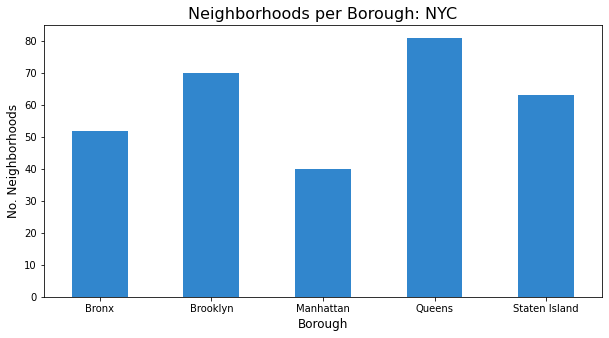

In [ ]:
clr = "#3186cd"
newyork_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. Neighborhoods',fontsize = 12)
plt.xticks(rotation = 'horizontal')
plt.show()

### Queens is the largest Borough with more than 80 Neighborhoods. Brooklyn, the second largest Borough account almost 70 Borough

## Locating using Foursquare

In [ ]:
CLIENT_ID = 'N5FHYAAPJ40G5EWXDZ5CPPENEPTY53H4XIEY4U5BNVCV5FI1'
CLIENT_SECRET = 'PR31X0GSWRT2IL0WIWXSYYSWGO1MEUJTXG4ZV0BFBVCOB5ZI'
VERSION = '20210120'
LIMIT = 30

# French restaurants located

In [ ]:
# French restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in newyork_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_rest=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(newyork_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_rest)))
    print(row)
    for rest_detail in french_rest.values.tolist():
        id, name , category=rest_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) French Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

In [ ]:
# Save the information to a .csv file
french_rest_ny.to_csv('french_rest_ny_tocsv1.csv', index=False) 

In [ ]:
french_rest_ny = pd.read_csv('french_rest_ny_tocsv1.csv')
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage


In [ ]:
french_rest_ny.tail()

,Borough,Neighborhood,ID,Name
47,Manhattan,Midtown South,5b06b57962845c00242fb6be,Maison Kayser
48,Manhattan,Sutton Place,4b70825df964a520e01e2de3,Bistro Vendome
49,Manhattan,Turtle Bay,4a64fda8f964a52023c71fe3,Deux Amis
50,Queens,Sunnyside Gardens,57f57d5dcd1047e759ea8838,Côté Soleil
51,Queens,Sunnyside Gardens,4eceef679a52262b810ab3bd,Bliss 46 Bistro


In [ ]:
french_rest_ny.shape

(52, 4)

### There are only 52 French restaurants in New York city

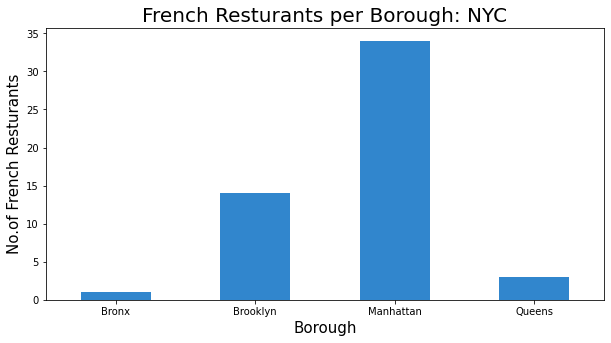

In [ ]:
french_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('French Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Queens']

,Borough,Neighborhood,ID,Name
39,Queens,Bayside,54823da3498e2f6041ab87e2,apertif
50,Queens,Sunnyside Gardens,57f57d5dcd1047e759ea8838,Côté Soleil
51,Queens,Sunnyside Gardens,4eceef679a52262b810ab3bd,Bliss 46 Bistro


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Manhattan']

,Borough,Neighborhood,ID,Name
15,Manhattan,Central Harlem,4b80389ff964a520e95d30e3,Yatenga
16,Manhattan,Central Harlem,59cc6158c0af57432b9fd02b,Renaissance Harlem
17,Manhattan,East Harlem,553c1b00498e7eb81316bf1b,Mountain Bird
18,Manhattan,Upper East Side,3fd66200f964a5207fe91ee3,Café Boulud
19,Manhattan,Upper East Side,533b5715498ee1e90e846e1d,The Simone
20,Manhattan,Upper East Side,4408540af964a52055301fe3,Orsay
21,Manhattan,Lenox Hill,4f5977dee4b0e4b75e4295d6,Jean Claude II
22,Manhattan,Lenox Hill,51a7b2ebabd809839bcfa1da,Brasserie Cognac East
23,Manhattan,Lincoln Square,478cd1f3f964a520444d1fe3,Bar Boulud
24,Manhattan,Clinton,3fd66200f964a5208de91ee3,Chez Josephine


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Manhattan'].shape

(34, 4)

In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Brooklyn']

,Borough,Neighborhood,ID,Name
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage
5,Brooklyn,Cobble Hill,4f7f8b86e4b088077df30175,Chez Moi
6,Brooklyn,Carroll Gardens,5df42352f93ca9000762ff64,Bar Bête
7,Brooklyn,Carroll Gardens,4e2ca88afa76bbf847e6886c,Jolie Bistro
8,Brooklyn,Fort Greene,5250553911d262bb0c732ee8,Cafe Paulette
9,Brooklyn,Fort Greene,422b9980f964a520d21f1fe3,Maison May
10,Brooklyn,Downtown,5ca3681932b61d0039533330,Pret A Manger


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Brooklyn'].shape

(14, 4)

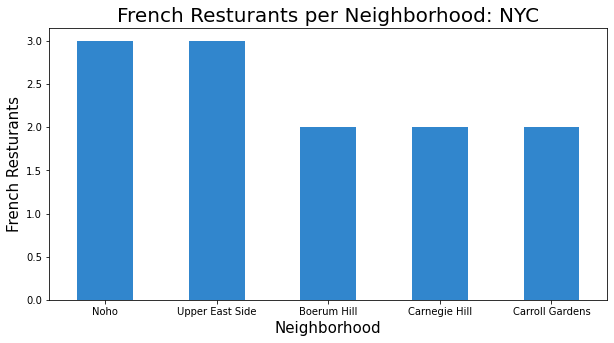

In [ ]:
Num_Neigh = 5 # top 5 for graphing 
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(Num_Neigh).plot.bar(figsize=(10,5), color=clr)
plt.title('French Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

## Locating using Foursquare

In [ ]:
CLIENT_ID = 'N5FHYAAPJ40G5EWXDZ5CPPENEPTY53H4XIEY4U5BNVCV5FI1'
CLIENT_SECRET = 'PR31X0GSWRT2IL0WIWXSYYSWGO1MEUJTXG4ZV0BFBVCOB5ZI'
VERSION = '20210120'
LIMIT = 30

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
stats_french_rest=pd.DataFrame(columns=column_names)
count=1
for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5 # 0 if does not exist in foursquare
    print('(',count,'/',len(french_rest_ny),')','processed')
    stats_french_rest = stats_french_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
stats_french_rest.head()

{'meta': {'code': 200, 'requestId': '602d770979984642d3bc5f64'}, 'response': {'venue': {'id': '4d7aa83ee540f04d66ba16dc', 'name': 'Bistro SK', 'contact': {'phone': '7188851670', 'formattedPhone': '(718) 885-1670'}, 'location': {'address': '273 City Island Ave', 'lat': 40.84638676701103, 'lng': -73.78626182722242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84638676701103, 'lng': -73.78626182722242}, {'label': 'entrance', 'lat': 40.846234, 'lng': -73.786269}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['273 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bistro-sk/4d7aa83ee540f04d66ba16dc', 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats

KeyError: 'venue'

In [ ]:
stats_french_rest.to_csv('stats_french_rest_csv.csv', index=False)

In [ ]:
stats_french_rest = pd.read_csv('stats_french_rest_csv.csv')
stats_french_rest.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,23,8.6,3
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,159,7.8,73
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro,55,7.4,32
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage,99,7.9,25


In [ ]:
stats_french_rest.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
45,Manhattan,Civic Center,534c9d7b498e1bdd443a40e1,Racines,120,8.5,37
46,Manhattan,Civic Center,3fd66200f964a52083e61ee3,The Odeon,722,8.7,210
47,Manhattan,Midtown South,5b06b57962845c00242fb6be,Maison Kayser,34,8.1,5
48,Manhattan,Sutton Place,4b70825df964a520e01e2de3,Bistro Vendome,30,8.1,10
49,Manhattan,Turtle Bay,4a64fda8f964a52023c71fe3,Deux Amis,50,8.3,23


In [ ]:
stats_french_rest.shape

(50, 7)

In [ ]:
stats = stats_french_rest.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
stats.columns=['Borough','Average Rating']
stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,8.450000
1,Brooklyn,8.064286
0,Bronx,7.500000
3,Queens,0.000000


## Queens' Map

In [ ]:
address = 'Queens,NYC'

geolocator = Nominatim(user_agent='foursquare_agent')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Queens,NYC are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Queens,NYC are 40.7498243, -73.7976337.


In [ ]:
map_Queens = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
for lat, lng, nei in zip(newyork_data['Latitude'], newyork_data['Longitude'], newyork_data['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Queens)  
    
map_Queens